# Лабораторная работа №5: Ансамбли моделей машинного обучения.

**Цель лабораторной работы:** изучение ансамблей моделей машинного обучения.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

from heamy.estimator import Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

from gmdhpy import gmdh

## Загрузка данных

In [2]:
data = pd.read_csv('data.csv')
data.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,in_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


## Обзор данных

In [3]:
profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)

In [4]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_school            1000 non-null   object 
 1   school_accreditation   1000 non-null   object 
 2   gender                 1000 non-null   object 
 3   interest               1000 non-null   object 
 4   residence              1000 non-null   object 
 5   parent_age             1000 non-null   int64  
 6   parent_salary          1000 non-null   int64  
 7   house_area             1000 non-null   float64
 8   average_grades         1000 non-null   float64
 9   parent_was_in_college  1000 non-null   bool   
 10  in_college             1000 non-null   bool   
dtypes: bool(2), float64(2), int64(2), object(5)
memory usage: 72.4+ KB


In [6]:
data.describe()

,parent_age,parent_salary,house_area,average_grades
count,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,52.208000,5.381570e+06,74.515300,86.097200
std,3.500427,1.397546e+06,15.293346,3.378738
min,40.000000,1.000000e+06,20.000000,75.000000
25%,50.000000,4.360000e+06,64.600000,83.737500
50%,52.000000,5.440000e+06,75.500000,85.575000
75%,54.000000,6.382500e+06,84.825000,88.262500
max,65.000000,1.000000e+07,120.000000,98.000000


<AxesSubplot:>

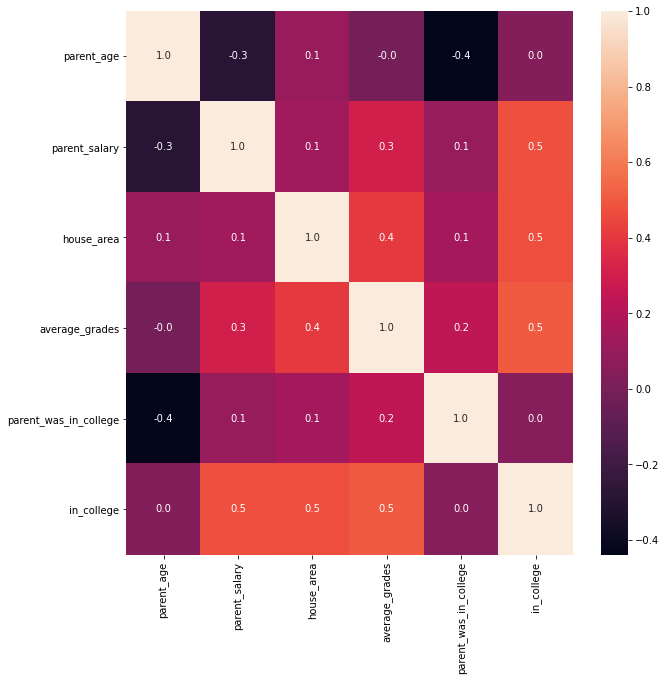

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), annot=True, fmt='.1f')

## Предобработка данных

Проведем кодирование категориальных признаков

In [8]:
cat_cols = []

In [9]:
for column in data.columns:
    if (data[column].dtypes == object) or (data[column].dtypes == bool):
        cat_cols.append(column)
cat_cols

['type_school',
 'school_accreditation',
 'gender',
 'interest',
 'residence',
 'parent_was_in_college',
 'in_college']

In [10]:
data_ohe = pd.get_dummies(data, columns=cat_cols, drop_first=True)

In [11]:
data_ohe.head()

,parent_age,parent_salary,house_area,average_grades,type_school_Vocational,school_accreditation_B,gender_Male,interest_Not Interested,interest_Quiet Interested,interest_Uncertain,interest_Very Interested,residence_Urban,parent_was_in_college_True,in_college_True
0,56,6950000,83.0,84.09,0,0,1,0,0,0,0,1,0,1
1,57,4410000,76.8,86.91,0,0,1,0,0,0,0,1,0,1
2,50,6500000,80.6,87.43,0,1,0,0,0,0,1,1,0,1
3,49,6600000,78.2,82.12,1,1,1,0,0,0,1,0,1,1
4,57,5250000,75.1,86.79,0,0,0,0,0,0,1,1,0,0


Пропуски в данных отстутсвуют, перейдем к следующему этапу подготовки данных

In [12]:
features = data_ohe.drop('in_college_True', axis=1)
target = data_ohe['in_college_True']

In [13]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=1, test_size=0.25)

In [14]:
print(features_train.shape[0], features_test.shape[0])

750 250


In [15]:
print(target_train.shape[0], target_test.shape[0])

750 250


## Обучение моделей

### Модель беггинга - Сверхслучайные деревья

In [16]:
model_ET = ExtraTreesClassifier(random_state=1)

In [17]:
model_ET.fit(features_train, target_train)

ExtraTreesClassifier(random_state=1)

In [18]:
predictions_ET = model_ET.predict(features_test)

In [19]:
print(roc_auc_score(target_test, predictions_ET))

0.8999615975422427


### Модель бустинга - Градиентный бустинг(XGBoost)

In [20]:
model_XGB = XGBClassifier()

In [21]:
model_XGB.fit(features_train, target_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [22]:
predictions_XGB = model_XGB.predict(features_test)

In [23]:
print(roc_auc_score(target_test, predictions_XGB))

0.9079621095750129


### Модель стекинга

In [24]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

In [25]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(features_train, target_train)
    y_pred = model.predict(features_test)
    result = roc_auc_score(target_test, y_pred)
    print(model)
    print('F1={}'.format(result))

In [26]:
for model in [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=50)
]:
    val_mae(model)
    print('==========================')
    print()

LogisticRegression()
F1=0.5

DecisionTreeClassifier()
F1=0.8239247311827957

RandomForestClassifier(n_estimators=50)
F1=0.8959933435739887



In [27]:
# Используем библиотеку heamy
# набор данных
dataset = Dataset(features_train, target_train, features_test)

# модели первого уровня
model_tree = Classifier(dataset=dataset, estimator=DecisionTreeClassifier, name='tree')
model_lr = Classifier(dataset=dataset, estimator=LogisticRegression ,name='lr')
model_rf = Classifier(dataset=dataset, estimator=RandomForestClassifier, parameters={'n_estimators': 50},name='rf')

In [28]:
# Эксперимент 1
# Первый уровень - две модели: решающее дерево и логистическая регрессия
# Второй уровень: линейная регрессия

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Classifier(dataset=stack_ds, estimator=LogisticRegression)
results = stacker.validate(k=10, scorer=roc_auc_score)

Metric: roc_auc_score
Folds accuracy: [0.8160173160173161, 0.8603988603988603, 0.9614814814814816, 0.8335724533715926, 0.8678571428571429, 0.895448079658606, 0.8903133903133903, 0.8816355810616929, 0.8640988372093023, 0.8570381231671553]
Mean accuracy: 0.872786126553654
Standard Deviation: 0.037453392087128175
Variance: 0.0014027565788321554


In [29]:
# Эксперимент 2
# Первый уровень - две модели: дерево и логистическая регрессия
# Второй уровень: случайный лес

stacker = Classifier(dataset=stack_ds, estimator=RandomForestClassifier)
results = stacker.validate(k=10, scorer=roc_auc_score)

Metric: roc_auc_score
Folds accuracy: [0.7525252525252526, 0.7841880341880342, 0.8866666666666667, 0.7725968436154949, 0.7885714285714286, 0.8556187766714083, 0.8557692307692308, 0.8611908177905309, 0.8288517441860465, 0.813049853372434]
Mean accuracy: 0.8199028648356528
Standard Deviation: 0.042291818802599
Variance: 0.0017885979376318667


In [30]:
# Эксперимент 3
# Первый уровень - три модели: дерево, логистическая регрессия регрессия и случайный лес
# Второй уровень: логистическая регрессия
pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Classifier(dataset=stack_ds3, estimator=LogisticRegression)
results = stacker.validate(k=10,scorer=roc_auc_score)

Metric: roc_auc_score
Folds accuracy: [0.9393939393939394, 0.9558404558404558, 0.9792592592592593, 0.9519368723098995, 0.9607142857142857, 0.9644381223328593, 0.9394586894586895, 0.9713055954088953, 0.9534883720930232, 0.9743401759530792]
Mean accuracy: 0.9590175767764387
Standard Deviation: 0.01298539212872517
Variance: 0.0001686204087367576


In [31]:
# Эксперимент 4
# Первый уровень - три модели: дерево, логистическая регрессия регрессия и случайный лес
# Второй уровень: случайный лес
stacker = Classifier(dataset=stack_ds3, estimator=RandomForestClassifier)
results = stacker.validate(k=10,scorer=roc_auc_score)

Metric: roc_auc_score
Folds accuracy: [0.93001443001443, 0.9448005698005698, 0.9562962962962963, 0.9476327116212339, 0.9339285714285714, 0.9523470839260313, 0.9415954415954415, 0.9806312769010042, 0.9215116279069767, 0.9787390029325513]
Mean accuracy: 0.9487497012423105
Standard Deviation: 0.018347482098213904
Variance: 0.00033663009934427974


In [32]:
# Результаты
array_labels = ['LR','TREE', 'RF', 'TREE+LR=>LR', 
                'TREE+LR=>RF', 'TREE+LR+RF=>LR', 'TREE+LR+RF=>RF']
array_mae = [0.5, 0.827956989247312, 0.8917690732206861, 
             0.872786126553654, 0.8199028648356528, 0.9590175767764387, 
             0.9487497012423105]

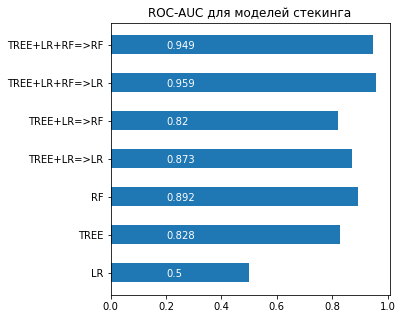

In [33]:
# Визуализация результатов
vis_models_quality(array_mae, array_labels, 'ROC-AUC для моделей стекинга')

### Модель многослойного персептрона

In [34]:
model_MLP = MLPClassifier(random_state=1)

In [35]:
model_MLP.fit(features_train, target_train)

MLPClassifier(random_state=1)

In [36]:
predictions_MLP = model_MLP.predict(features_test)

In [37]:
print(roc_auc_score(target_test, predictions_MLP))

0.5
